In [24]:
# 導入必要的庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [25]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# 查看數據的前幾行
print(train_data.head())
print(test_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

訓練集形狀: (891, 12)
測試集形狀: (418, 11)

訓練集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

測試集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  


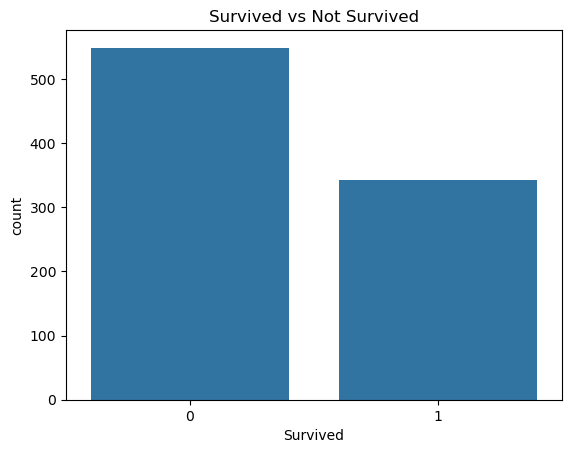

In [26]:
# 數據探索
print("訓練集形狀:", train_data.shape)
print("測試集形狀:", test_data.shape)
print("\n訓練集信息:")
print(train_data.info())
print("\n測試集信息:")
print(test_data.info())

# 查看缺失值
print("\n訓練集缺失值:")
print(train_data.isnull().sum())
print("\n測試集缺失值:")
print(test_data.isnull().sum())

# 可視化生還比例
sns.countplot(x='Survived', data=train_data)
plt.title('Survived vs Not Survived')
plt.show()

In [27]:
# 處理缺失值
# 填充年齡的中位數
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# 填充登船港口的最常見值
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# 刪除 Cabin 特徵（缺失值過多）
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# 創建新特徵：家庭大小
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# 創建新特徵：是否獨自旅行
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

# 刪除不必要的特徵
train_data.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

C:\Users\sam\AppData\Local\Temp\ipykernel_26220\2593712799.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\sam\AppData\Local\Temp\ipykernel_26220\2593712799.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [28]:
print("訓練集形狀:", train_data.shape)
print("測試集形狀:", test_data.shape)

訓練集形狀: (891, 8)
測試集形狀: (418, 7)


In [30]:
# 定義數值型和類別型特徵
numerical_features = ['Age', 'Fare', 'FamilySize', 'IsAlone']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 創建預處理管道
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# 分離特徵和目標變量
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

In [31]:
# 定義 K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型列表
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(kernel='linear', random_state=42)
}

# 訓練並評估模型
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    results[name] = cv_scores.mean()
    print(f"{name} K-Fold 交叉驗證準確率: {cv_scores.mean():.4f}")

Logistic Regression K-Fold 交叉驗證準確率: 0.8047
Decision Tree K-Fold 交叉驗證準確率: 0.7710
Random Forest K-Fold 交叉驗證準確率: 0.8159
Gradient Boosting K-Fold 交叉驗證準確率: 0.8272


c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

CatBoost K-Fold 交叉驗證準確率: 0.8294
KNN K-Fold 交叉驗證準確率: 0.8047
SVM K-Fold 交叉驗證準確率: 0.7924


In [32]:
# 選擇最佳模型
best_model_name = max(results, key=results.get)
print(f"\n最佳模型: {best_model_name}, 準確率: {results[best_model_name]:.4f}")

# 擬合整個訓練集
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_name])
])
best_model.fit(X, y)

# 對測試集進行預測
test_predictions = best_model.predict(test_data)

# 保存預測結果
submission = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv')['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('titanic_submission.csv', index=False)
print("預測結果已保存為 titanic_submission.csv")


最佳模型: LightGBM, 準確率: 0.8306
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
預測結果已保存為 titanic_submission.csv


c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
